In [1]:
import os
import sys

sys.path.append('../')

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import gridspec
from matplotlib.colors import LogNorm, Normalize
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from torch.optim import Adam
from tqdm import tqdm

from kwave.ktransducer import kWaveGrid
from models.apact import APACT
from models.das import DAS, Dual_SOS_DAS
from models.nf_apact import NF_APACT
from models.pact import TF_PACT, Wavefront_SOS
from models.deconv import MultiChannel_Deconv
from utils.data import *
from utils.dataset import get_jr_dataloader
from utils.reconstruction import *
from utils.simulations import get_water_SOS
from utils.utils_torch import get_total_params
from utils.visualization import *

os.environ["CUDA_VISIBLE_DEVICES"] = '1'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_path = '../data/'
results_path = '../results/'

### Load Sinogram

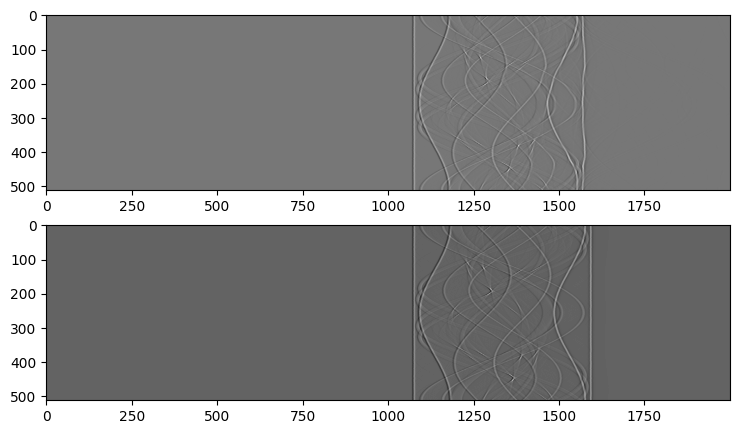

In [2]:
sinogram = load_mat(os.path.join(data_path, 'sinogram_simulation_easy.mat'))
sinogram_uniform = load_mat(os.path.join(data_path, 'sinogram_simulation_uniform.mat'))

plt.figure(figsize=(12,5))
plt.subplot(2,1,1)
plt.imshow(sinogram, cmap='gray')
plt.subplot(2,1,2)
plt.imshow(sinogram_uniform, cmap='gray')
plt.show()

### Load SoS

In [3]:
SOS = load_mat(os.path.join(data_path, 'SoS_easy.mat'))
# # SoS_error = load_mat(os.path.join(data_path, 'SoS_error.mat'))
# SOS_jr = load_mat(os.path.join(results_path, 'SOS_jr_simulation.mat'))


# fig = plt.figure(figsize=(11, 6))
# norm = Normalize(vmax=1600, vmin=1500)
# plt.subplot(1,2,1)
# plt.title('True SoS', fontsize=14)
# plt.imshow(SOS, norm=norm, cmap='magma')
# plt.axis('off')

# ax = plt.subplot(1,2,2)
# plt.title('SoS with Error', fontsize=14)
# plt.imshow(SOS_jr, norm=norm, cmap='magma')
# plt.axis('off')
# cax = fig.add_axes([ax.get_position().x1+0.03, ax.get_position().y0, 0.02, ax.get_position().height])
# cb = plt.colorbar(cax=cax, norm=norm)
# cb.ax.set_yticks([1500, 1520, 1540, 1560, 1580, 1600])
# cb.ax.tick_params(labelsize=12)

### Preparations

First, we need to define the size and resolution of the image. We also calculate the X and Y coordinates of each pixels in the image.

In [4]:
Nx, Ny = 560, 560
dx, dy = 4e-5, 4e-5
kgrid = kWaveGrid([Nx, Ny], [dx, dy])
x_vec, y_vec = kgrid.x_vec, kgrid.y_vec
l = 3.2e-3 # Patch size [m].

Next, we define parameters of the single-body SoS for the following wavefront and PSF calculations.

In [5]:
R = 9.8e-3              # Radius of single body [m].
T = 26.0                # Water temperature [C].
v0 = get_water_SOS(T)   # Background SoS [m/s].
v1 = 1558#1567.3             # Avergae SoS in single body [m/s].
print(v0, v1)

1499.3632858457756 1558


Calculate the gaussian kernel which smooths the image boundaries when merging image patches.

In [6]:
fwhm = 1.5e-3 # [m]
sigma = fwhm / 4e-5 / np.sqrt(2*np.log(2))
gaussian_window = torch.tensor(gaussian_kernel(sigma, 80)).cuda()

Initialize the delay-and-sum model.

In [7]:
das = DAS(R_ring=0.05, N_transducer=512, T_sample=1/40e6, x_vec=x_vec, y_vec=y_vec, mode='zero')
das.cuda()
das.eval()

DAS()

### Uniform SoS

In [8]:
import time
with torch.no_grad():
    gt = das(sinogram=torch.tensor(sinogram_uniform).cuda(), 
             v0=v0, d_delay=0, ring_error=0).detach().cpu().numpy()

In [9]:
save_mat(os.path.join(results_path, 'gt_simulation.mat'), gt.swapaxes(0,1), 'img')

### Conventional DAS

In [10]:
with torch.no_grad():
    rec_das = das(sinogram=torch.tensor(sinogram).cuda(),
                  v0=torch.tensor(1510.5).cuda(),
                  d_delay=torch.zeros(1).cuda(),
                  ring_error=torch.zeros(1).cuda()).detach().cpu().numpy()

In [11]:
save_mat(os.path.join(results_path, 'das_simulation_easy.mat'), rec_das.swapaxes(0,1), 'img')

### Dual SoS DAS

In [12]:
das_dual = Dual_SOS_DAS(R_ring=0.05, N_transducer=512, T_sample=1/40e6, x_vec=x_vec, y_vec=y_vec, R_body=R, center=(0.0, 0.0), mode='zero')
das_dual.cuda()
das_dual.eval()

Dual_SOS_DAS()

In [13]:
with torch.no_grad():
    rec_das_dual = das_dual(sinogram=torch.tensor(sinogram).cuda(),
                            v0=torch.tensor(v0).cuda(),
                            v1=torch.tensor(v1).cuda(),
                            d_delay=torch.zeros(1).cuda(), 
                            ring_error=torch.zeros(1).cuda()).detach().cpu().numpy()

In [14]:
save_mat(os.path.join(results_path, 'das_dual_simulation_easy.mat'), rec_das_dual.swapaxes(0,1), 'img')

### APACT

In [15]:
# delays_apact = np.arange(-8e-4, 8e-4, 0.5e-4) # Delay distances [m].

# apact = APACT(delays=delays_apact, dc_range=[-2e-4, 1.6e-4], amp=3.2e-4, step=4e-5, data_path='./TF_simulation/', device=device)
# apact.cuda()
# apact.eval()

In [16]:
# img_stack = []
# with torch.no_grad():
#     for d_delay in tqdm(delays_apact):
#         recon = das(sinogram=torch.tensor(sinogram).cuda(), 
#                     v0=torch.tensor(1510.5).cuda(),
#                     d_delay=torch.tensor(d_delay).cuda(),
#                     ring_error=torch.zeros(1).cuda())
#         img_stack.append(recon)
# img_stack = torch.stack(img_stack, dim=0)

In [17]:
# def deconv_full_apact(model, img_stack, gaussian_window):
#     rec_apact = torch.zeros_like(img_stack[0]).cuda()
#     with torch.no_grad():
#         for idx in tqdm(range(625)):
#             i, j = idx // 25, idx % 25
#             obs = img_stack[:,20*i:20*i+80, 20*j:20*j+80] * gaussian_window
#             obs = obs.unsqueeze(0).cuda()
#             rec, _, _, _ = model(obs)
#             rec_apact[20*i:20*i+80, 20*j:20*j+80] += rec.squeeze(0).squeeze(0)
#     return rec_apact.detach().cpu().numpy()

# rec_apact = deconv_full_apact(apact, img_stack, gaussian_window)

In [18]:
# save_mat(os.path.join(results_path, 'apact_simulation_easy.mat'), rec_apact.swapaxes(0,1), 'img')

### Joint Reconstruction

In [20]:
n_delays = 32
delays = np.linspace(-8e-4, 8e-4, n_delays)

img_stack = []
with torch.no_grad():
    for d_delay in tqdm(delays, desc='DAS'):
        recon = das(sinogram=torch.tensor(sinogram).cuda(), v0=v0, d_delay=d_delay, ring_error=0)
        img_stack.append(recon)
img_stack = torch.stack(img_stack, dim=0)

DAS:   0%|          | 0/32 [00:00<?, ?it/s]


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [10]:
img_stack = (img_stack - img_stack.mean()) / img_stack.std()
data_loader = get_jr_dataloader(img_stack, l)

kgrid = kWaveGrid([Nx, Ny], [dx, dy])
x_vec, y_vec = kgrid.x_vec, kgrid.y_vec

In [54]:
joint_recon = NF_APACT(mode='SIREN', mean=1542, std=70, lam_tv=0.3e-11, #0.7e-3,
                          x_vec=x_vec, y_vec=y_vec, R=R, v0=v0, n_points=80, l=3.2e-3, n_delays=n_delays, angle_range=(0, 2*torch.pi))
joint_recon.cuda()
print("Number of parameter: %s" % (get_total_params(joint_recon)))

optimizer = Adam(params=joint_recon.parameters(), lr=2.e-5)

Number of parameter: 11233


In [55]:
n_epochs = 100
loss_list = []
for epoch in range(n_epochs):
    joint_recon.train()
    train_loss = 0.0
    for x, y, img in data_loader:
        x, y, img = x.cuda(), y.cuda(), img.cuda()
        rec_jr, SOS_jr, loss = joint_recon(x, y, img, torch.tensor(delays).cuda())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    loss_list.append(train_loss)
    print("Joint Reconstruction:  [{}/{}]  loss={:0.4g} ".format(epoch+1, n_epochs, train_loss/len(data_loader)))

Joint Reconstruction:  [1/100]  loss=6.149e-05 
Joint Reconstruction:  [2/100]  loss=5.227e-05 
Joint Reconstruction:  [3/100]  loss=4.963e-05 
Joint Reconstruction:  [4/100]  loss=4.897e-05 
Joint Reconstruction:  [5/100]  loss=4.862e-05 
Joint Reconstruction:  [6/100]  loss=4.842e-05 
Joint Reconstruction:  [7/100]  loss=4.829e-05 
Joint Reconstruction:  [8/100]  loss=4.814e-05 
Joint Reconstruction:  [9/100]  loss=4.804e-05 
Joint Reconstruction:  [10/100]  loss=4.799e-05 
Joint Reconstruction:  [11/100]  loss=4.795e-05 
Joint Reconstruction:  [12/100]  loss=4.785e-05 
Joint Reconstruction:  [13/100]  loss=4.778e-05 
Joint Reconstruction:  [14/100]  loss=4.773e-05 
Joint Reconstruction:  [15/100]  loss=4.772e-05 
Joint Reconstruction:  [16/100]  loss=4.76e-05 
Joint Reconstruction:  [17/100]  loss=4.766e-05 
Joint Reconstruction:  [18/100]  loss=4.761e-05 
Joint Reconstruction:  [19/100]  loss=4.757e-05 
Joint Reconstruction:  [20/100]  loss=4.757e-05 
Joint Reconstruction:  [21/100

In [ ]:
SOS_jr = SOS_jr.detach().cpu().numpy()

In [ ]:
SOS_jr.mean(), SOS_jr.std(), SOS_jr.max(), SOS_jr.min()

(1530.5309552505498, 32.22074845852187, 1629.6469659805298, 1470.3507215976715)

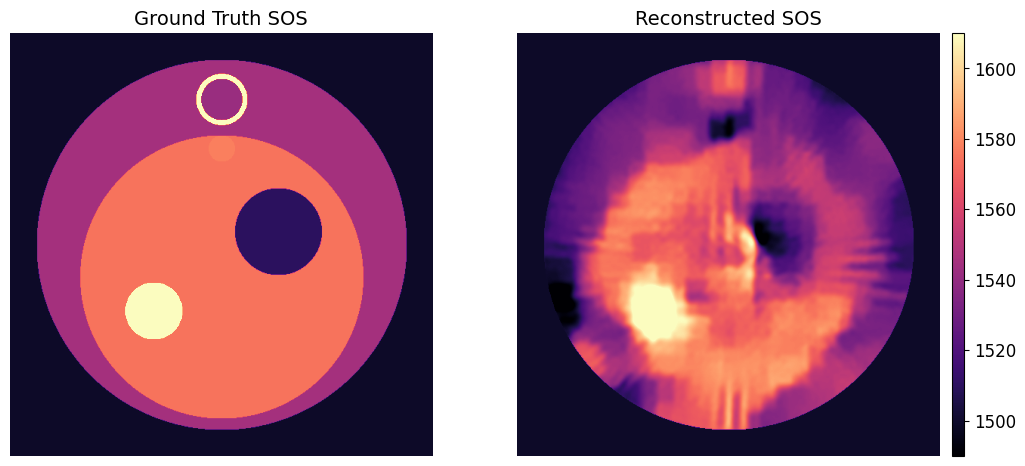

In [ ]:
fig = plt.figure(figsize=(12, 6))
norm = Normalize(vmax=1610, vmin=1490)

ax = plt.subplot(1, 2, 1)
plt.title('Ground Truth SOS', fontsize=14)
plt.imshow(SOS, norm=norm, cmap='magma')
plt.axis('off')

ax = plt.subplot(1, 2, 2)
plt.title('Reconstructed SOS', fontsize=14)
plt.imshow(SOS_jr, norm=norm, cmap='magma')
plt.axis('off')
cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.01, ax.get_position().height])
cb = plt.colorbar(cax=cax, norm=norm)
cb.ax.set_yticks([1500, 1520, 1540, 1560, 1580, 1600])
cb.ax.tick_params(labelsize=12)

In [ ]:
save_mat(os.path.join(results_path, 'SOS_jr_simulation_easy.mat'), SOS_jr.swapaxes(0,1), 'SOS')

### Deconvolution with Single Body PSFs

In [26]:
def deconv_full(img_stack, SoS, gaussian_window, delays, attention='uniform'):
    wavefront_sos = Wavefront_SOS(R, v0, x_vec, y_vec, n_points=180)
    wavefront_sos.cuda()
    wavefront_sos.eval()
    
    tf_pact = TF_PACT(n_points=160, l=6.4e-3, n_delays=delays.shape[0])
    tf_pact.cuda()
    tf_pact.eval()

    wiener = MultiChannel_Deconv(n_pixels=80, l_patch=3.2e-3)
    wiener.cuda()
    wiener.eval()
    
    img_stack /= img_stack.abs().mean()
    rec_full = torch.zeros_like(img_stack[0]).cuda()
    SoS = torch.tensor(SoS, dtype=torch.float64).cuda()
    with torch.no_grad():
        for idx in tqdm(range(625), desc='Deconvolution'):
            i, j = idx // 25, idx % 25
            x, y = (j-12)*l / 4, (12-i)*l / 4
            thetas, wfs = wavefront_sos(torch.tensor(x).cuda(), torch.tensor(y).cuda(), SoS)
            tf = tf_pact(torch.tensor(delays).cuda().view(-1,1,1), thetas, wfs)
            obs = img_stack[:,20*i:20*i+80, 20*j:20*j+80]
            obs = obs.unsqueeze(0) * gaussian_window
            rec = wiener(obs, tf)
            rec_full[20*i:20*i+80, 20*j:20*j+80] += rec.squeeze(0).squeeze(0)
    return rec_full.detach().cpu().numpy()

rec_deconv = deconv_full(img_stack, SOS, gaussian_window, delays)
# rec_jr = deconv_full(img_stack, SOS_jr, gaussian_window, delays)


Deconvolution: 100%|██████████| 625/625 [00:02<00:00, 227.56it/s]


In [28]:
rec_deconv.mean(), rec_deconv.std(), rec_deconv.max(), rec_deconv.min()

(7.485208179574167e-05,
 0.003203867874860498,
 0.020581132224805496,
 -0.008774889884208931)

In [ ]:
save_mat(os.path.join(results_path, 'deconv_simulation_easy.mat'), rec_deconv.swapaxes(0,1), 'img')
save_mat(os.path.join(results_path, 'jr_simulation_easy.mat'), rec_jr.swapaxes(0,1), 'img')
# save_mat(os.path.join(results_path, 'deconv_onehot_simulation_easy.mat'), rec_deconv_onehot.swapaxes(0,1), 'img')

### Visualization

Load and normalize images.

In [12]:
IP_img = load_mat(os.path.join(data_path, 'IP.mat'))
gt = load_mat(os.path.join(results_path, 'gt_simulation.mat'))
rec_das = load_mat(os.path.join(results_path, 'das_simulation_easy.mat'))
rec_das_dual = load_mat(os.path.join(results_path, 'das_dual_simulation_easy.mat'))
rec_apact = load_mat(os.path.join(results_path, 'apact_simulation_easy.mat'))
rec_deconv = load_mat(os.path.join(results_path, 'deconv_simulation_easy.mat'))
rec_jr = load_mat(os.path.join(results_path, 'jr_simulation_easy.mat'))    
rec_deconv_onehot = load_mat(os.path.join(results_path, 'deconv_onehot_simulation_easy.mat'))

In [29]:
[IP_img, gt, rec_das, rec_das_dual, rec_apact, rec_deconv, rec_jr, rec_deconv_onehot] = \
    [standardize(img) for img in [IP_img, gt, rec_das, rec_das_dual, rec_apact, rec_deconv, rec_jr, rec_deconv_onehot]]

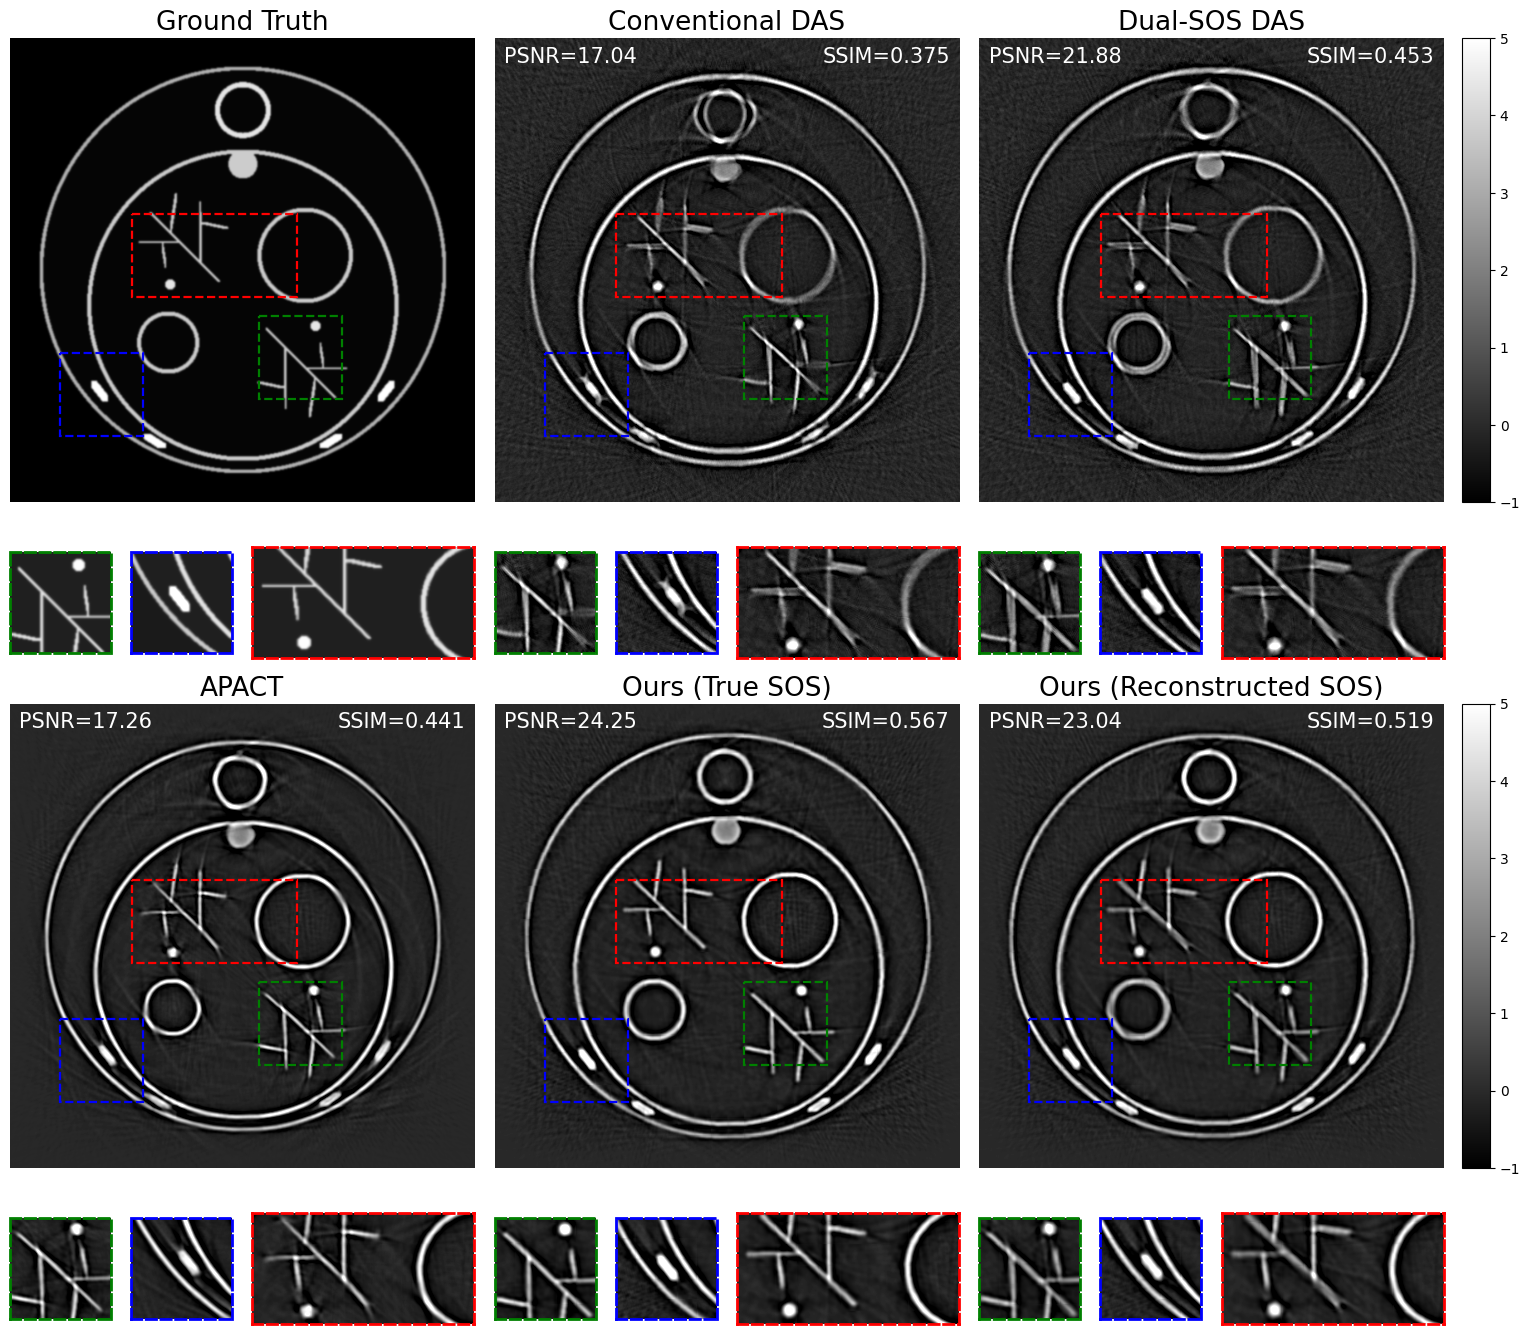

In [30]:
patches = [(335, 300, 100, 100, 'green'), (380, 60, 100, 100,'blue'), (212, 146, 100, 200, 'red')]

fig = plt.figure(figsize=(18.5, 17))
gs = gridspec.GridSpec(10, 12)
# norm = matplotlib.colors.Normalize(vmax=1, vmin=0)
norm = Normalize(vmax=5, vmin=-1)
for idx, (rec_full, method) in enumerate(zip([IP_img, rec_das, rec_das_dual, rec_apact, rec_deconv, rec_jr], \
                                             ['Ground Truth', 'Conventional DAS', 'Dual-SOS DAS', 'APACT', 'Ours (True SOS)', 'Ours (Reconstructed SOS)'])):
    ax = plt.subplot(gs[(idx//3)*5:(idx//3)*5+4,(idx%3)*4:(idx%3+1)*4])
    if idx == 0:
        plt.imshow(IP_img, cmap='gray', norm=Normalize(vmax=IP_img.max(), vmin=IP_img.min()))
    else:
        plt.imshow(rec_full, cmap='gray', norm=norm)
    plt.title(method, fontsize=19)
    if idx > 0:
        plt.title('PSNR={:.2f}'.format(psnr(IP_img, rec_full, data_range=10)), loc='left', x=0.02, y=0.93, fontsize=15, color='white')
        plt.title('SSIM={:.3f}'.format(ssim(IP_img, rec_full, data_range=10)), loc='right', x=0.98, y=0.93, fontsize=15, color='white')
    plt.axis('off')
    if idx % 3 == 2:
        cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.015, ax.get_position().height])
        cb = plt.colorbar(cax=cax)
    for k, (x, y, h, w, color) in enumerate(patches):
        rect = plt.Rectangle((y, x), w, h, fill=False, edgecolor=color, linewidth=1.6, linestyle='--')
        ax.add_patch(rect)
        ax2 = plt.subplot(gs[(idx//3)*5+4:(idx//3)*5+5,(idx%3)*4+k:(idx%3)*4+k+1+(k==2)])
        plt.imshow(rec_full[x:x+h, y:y+w], cmap='gray', norm=norm)
        plt.xticks([])
        plt.yticks([])
        for loc in ['bottom', 'top', 'left', 'right']:
            ax2.spines[loc].set_color(color)
            ax2.spines[loc].set_linewidth(2)
            ax2.spines[loc].set_linestyle('--')

In [ ]:
plt.imsave(os.path.join('../figures', 'rec_das_simulation.png'), rec_das, cmap='gray', vmin=-1, vmax=5)
plt.imsave(os.path.join('../figures', 'rec_jr_simulation.png'), rec_jr, cmap='gray', vmin=-1, vmax=5)

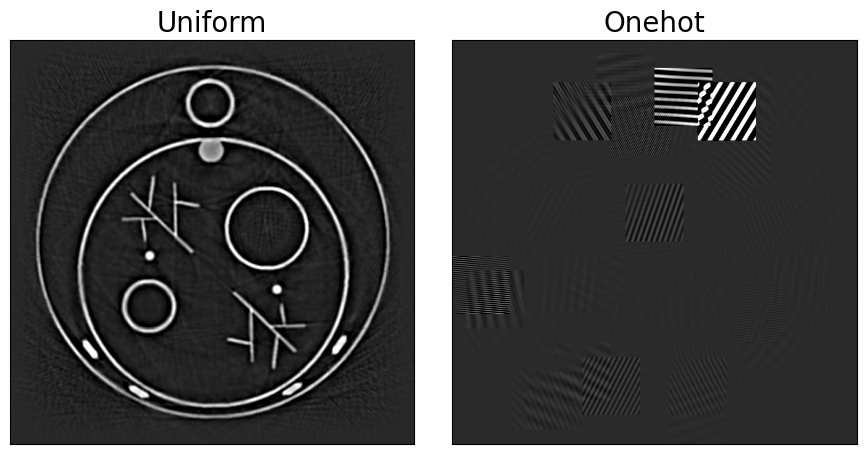

In [ ]:
fig = plt.figure(figsize=(9, 4.5))
for idx, (rec_full, attention) in enumerate(zip([rec_deconv, rec_deconv_onehot], ['Uniform', 'Onehot'])):
        ax = plt.subplot(1,2,idx+1)
        plt.imshow(rec_full, cmap='gray', norm=norm)
        plt.title(attention, fontsize=20)
        plt.xticks([])
        plt.yticks([])
plt.tight_layout()